Author: Krishnanjan Sil

This code implements GPR to reconstruct H(z) using simulated data from eLISA.

In [1]:
#Imported Libraries and Initial Setup
# --------------------------------------------------

# Install necessary libraries
!pip install emcee corner scikit-optimize #seaborn matplotlib numpy scipy astropy scikit-learn

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
import astropy.constants as const
import emcee
import multiprocessing
import time
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import warnings # Imported warnings module
from scipy.stats import beta as beta_distribution # Use scipy.stats.beta for both PDF and RVS

# Suppress specific warnings if needed
# warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=UserWarning)

'''
Plotting style:
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    print("Using seaborn-v0_8-whitegrid plot style.")
except OSError:
    print("Seaborn style 'seaborn-v0_8-whitegrid' not found. Using default.")
    plt.style.use('default')
'''

print("Libraries imported.")

# Ensure correct cpu count reporting even in restricted environments
try:
    n_cpus = multiprocessing.cpu_count()
    print(f"Using {n_cpus} CPU cores for parallel processing.")
except NotImplementedError:
    n_cpus = 1 # Default to 1 if cpu_count fails
    print("Could not determine CPU count. Defaulting to 1 core.")

# Define the number of mock catalogues/simulations
N_SIMULATIONS = 100 # Number of times to run GP over different mock data
print(f"Number of simulations set to: {N_SIMULATIONS}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00
Libraries imported.
Using 2 CPU cores for parallel processing.
Number of simulations set to: 100


In [2]:
# Cosmological Parameters for Vanilla Lambda CDM and Helper Functions
# --------------------------------------------------

c_km = const.c.to('km/s').value   # Speed of light in km/s
H0 = 70.0                         # Hubble constant (km/s/Mpc) - Fiducial value for simulation
Omega_m = 0.3                     # Matter density parameter
Omega_lambda = 1.0 - Omega_m      # Dark energy density parameter

print(f"Fiducial Cosmology: H0={H0}, Omega_m={Omega_m}, Omega_lambda={Omega_lambda}")

def E(z: float, Om: float = Omega_m, Ol: float = Omega_lambda) -> float:
    """Dimensionless Hubble parameter E(z) = H(z)/H0."""
    return np.sqrt(Om * (1 + z)**3 + Ol)

def dL_theory(z: float, H0_val: float = H0, Om: float = Omega_m, Ol: float = Omega_lambda) -> float:
    """Compute theoretical luminosity distance via integration."""
    inv_E = lambda zp: 1.0 / E(zp, Om, Ol)
    if isinstance(z, (np.ndarray, list)):
        # Ensure z is a numpy array for vectorized operations
        z_arr = np.asarray(z)
        # Calculate integrals for each redshift value
        integrals = np.array([quad(inv_E, 0, zi)[0] for zi in z_arr])
        # Calculate dL, ensuring dL=0 at z=0
        dL = np.zeros_like(z_arr, dtype=float)
        non_zero_z_mask = (z_arr != 0)
        # Avoid division by zero or 0*inf for the z=0 case before calculation
        z_arr_safe = np.where(non_zero_z_mask, z_arr, 1e-15) # Use tiny value for calculation if z=0
        dL[non_zero_z_mask] = (1 + z_arr_safe[non_zero_z_mask]) * (c_km / H0_val) * integrals[non_zero_z_mask]
        return dL
    else: # Handle scalar input
        if z == 0:
            return 0.0
        integral, _ = quad(inv_E, 0, z)
        return (1 + z) * (c_km / H0_val) * integral

print("Cosmological functions dL_theory(z) and E(z) defined.")

Fiducial Cosmology: H0=70.0, Omega_m=0.3, Omega_lambda=0.7
Cosmological functions dL_theory(z) and E(z) defined.


In [3]:
# Weak Lensing and Peculiar Velocity Error Models
# --------------------------------------------------

def weak_lensing_error(z: np.ndarray) -> np.ndarray:
    """Estimate weak lensing uncertainty on dL based on fiducial model."""
    z = np.asarray(z)
    dl = dL_theory(z) # Use fiducial cosmology for error estimation
    term = ((1 - (1+z)**-0.25) / 0.25)
    # Clip term to avoid potential issues with negative bases at very small z
    term = np.clip(term, a_min=1e-9, a_max=None)
    with np.errstate(invalid='ignore'): # Ignore potential NaNs during power calculation
        error_factor = 0.066 * (term**1.8)
    # Handle NaNs/Infs resulting from calculations, set error to 0 in those cases
    error_factor[np.isnan(error_factor) | np.isinf(error_factor)] = 0
    error = dl * error_factor
    error[z == 0] = 0 # Ensure error is exactly zero at z=0
    return error

def peculiar_velocity_error(z: np.ndarray, vp_rms: float = 500.0) -> np.ndarray:
    """Estimate peculiar velocity uncertainty on dL (vp_rms in km/s)."""
    z = np.asarray(z)
    dl = dL_theory(z) # Use fiducial cosmology for error estimation
    # Simple model: constant velocity uncertainty projected onto distance via Doppler shift effect
    # Error = dL * (vp_rms / c) / (1+z) - simplified further here: dL * vp_rms / c seems common
    # Ensure error is zero at z=0
    pv_err = np.zeros_like(dl)
    non_zero_z_mask = (z != 0)
    # Calculating error only for non-zero z to avoid division by zero or issues with dl=0
    pv_err[non_zero_z_mask] = dl[non_zero_z_mask] * (vp_rms / c_km)
    # Ensure error is strictly zero at z=0
    pv_err[z == 0] = 0.0
    return pv_err

print("Error models (Weak Lensing, Peculiar Velocity) defined.")

Error models (Weak Lensing, Peculiar Velocity) defined.


In [4]:
#  Redshift Data Generation Function
# --------------------------------------------------

def generate_z_data(scenario: str, num_events: int = 100, min_z: float = 0.01,
                         max_z_scale: float = 9.0, target_max_z: float = 9.0) -> np.ndarray:
    """
    Generates redshifts based on Beta distributions modeling different scenarios.
    Used scipy.stats.beta.rvs to sample directly from the scaled distribution.
    Ensures samples are within [min_z, target_max_z].
    Returns unique sorted redshifts as a column vector.
    """
    scenario = scenario.lower()

    if scenario == "delay":
        alpha_param, beta_param = 2.42, 3.84
    elif scenario == "pop iii":
        alpha_param, beta_param = 2.64, 6.03
    elif scenario == "no delay":
        alpha_param, beta_param = 2.14, 4.7
    else:
        raise ValueError("Scenario must be 'Delay', 'Pop III', or 'No Delay'")

    print(f"Generating redshifts for '{scenario}' scenario (alpha={alpha_param}, beta={beta_param})")

    z_samples = []
    max_attempts_multiplier = 15 # May need more attempts for tight constraints
    max_attempts = num_events * max_attempts_multiplier
    total_generated = 0
    target_oversampling_factor = 2.5 # How much to oversample in each batch

    # Sample redshifts until we have enough valid events within the desired range
    while len(z_samples) < num_events and total_generated < max_attempts:
        needed = int((num_events - len(z_samples)) * target_oversampling_factor) + 50 # Generous oversampling

        # Sampled directly from the scaled Beta distribution [loc, loc+scale]
        new_samples = beta_distribution.rvs(a=alpha_param, b=beta_param,
                                            loc=0, scale=max_z_scale,
                                            size=needed)
        total_generated += needed

        # Filter samples to be within the desired redshift range [min_z, target_max_z]
        valid_samples = new_samples[(new_samples >= min_z) & (new_samples <= target_max_z)]
        z_samples.extend(valid_samples)

    if len(z_samples) < num_events:
         print(f"Warning: Only generated {len(z_samples)} events in desired range [{min_z}, {target_max_z}] after sampling {total_generated} points.")

    # Return the required number of samples, ensure uniqueness, sort, and reshape
    final_samples = np.array(z_samples[:num_events])
    unique_final_samples = np.unique(final_samples) # Ensure unique redshifts
    if len(unique_final_samples) < len(final_samples):
        print(f"Warning: Removed {len(final_samples) - len(unique_final_samples)} duplicate redshift values.")

    return np.sort(unique_final_samples).reshape(-1, 1) # Return as column vector

print("Redshift data generation function 'generate_z_data' defined.")

Redshift data generation function 'generate_z_data' defined.


In [5]:
# Luminosity Distance Observation Generation Function
# --------------------------------------------------

def generate_dL_obs(z_data_flat: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates observed dL with combined lensing and peculiar velocity errors.
    Input: Flattened 1D array of redshifts.
    Output: dL_obs (1D array), dL_err (1D array).
    Ensures dL=0 and err=0 at z=0 if z=0 is present in input.
    """
    # Ensure input is flat numpy array
    z_data_flat = np.asarray(z_data_flat).flatten()

    dL_obs, dL_err = [], []
    # Calculate theoretical dL and errors based on the fiducial cosmology
    dL_th_vals = dL_theory(z_data_flat)
    sigma_lens_vals = weak_lensing_error(z_data_flat)
    sigma_vel_vals = peculiar_velocity_error(z_data_flat)

    for i, z in enumerate(z_data_flat):
        dL_th = dL_th_vals[i]
        # Ensure non-negative errors
        sigma_lens = max(0, sigma_lens_vals[i])
        sigma_vel = max(0, sigma_vel_vals[i])
        # Combine errors in quadrature
        total_sigma = np.sqrt(sigma_lens**2 + sigma_vel**2)

        # Add a small relative floor to sigma if it's zero *except* for z=0
        floor_val = 1e-5 * abs(dL_th) if abs(dL_th) > 1e-9 else 1e-7
        if total_sigma < floor_val and z != 0:
             total_sigma = floor_val
        elif z == 0:
             total_sigma = 0.0 # Ensure error is strictly zero at z=0

        # Generate Gaussian noise based on the total error
        # Ensure sigma is non-negative for np.random.normal
        noise = np.random.normal(0, max(0, total_sigma))
        # Observed dL is theory + noise
        dL_obs.append(dL_th + noise)
        # Store the total error for this point (ensure non-negative)
        dL_err.append(max(0, total_sigma))

    return np.array(dL_obs), np.array(dL_err)

print("Luminosity distance data generation function 'generate_dL_obs' defined.")

Luminosity distance data generation function 'generate_dL_obs' defined.


In [6]:
#  Function to Add dL(z=0)=0 Constraint
# --------------------------------------------------

def add_z0_constraint(z_data: np.ndarray, dL_obs: np.ndarray, dL_err: np.ndarray,
                      z0_err_val: float = 1e-9) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepends the (z=0, dL=0) constraint to the dataset.
    Inputs:
        z_data: Redshifts (N, 1) or (N,) array.
        dL_obs: Observed dL (N,) array.
        dL_err: Errors on dL (N,) array.
        z0_err_val: The small error to assign to the dL(0) point.
    Outputs:
        Constrained z_data (N+1, 1), dL_obs (N+1,), dL_err (N+1,), dL_err_sq (N+1,).
    """
    # Ensure z_data is a column vector (N, 1)
    z_data = np.asarray(z_data).reshape(-1, 1)
    dL_obs = np.asarray(dL_obs)
    dL_err = np.asarray(dL_err)

    # Check if z=0 is already present
    if 0.0 in z_data:
        print("Warning: z=0 already present in data. Modifying its dL and error.")
        z0_idx = np.where(z_data == 0.0)[0][0]
        dL_obs[z0_idx] = 0.0
        dL_err[z0_idx] = z0_err_val
        z_data_constrained = z_data
        dL_obs_constrained = dL_obs
        dL_err_constrained = dL_err
    else:
        # Prepend z=0
        z_data_constrained = np.vstack([[[0.]], z_data]) # Shape (N+1, 1)
        # Prepend dL=0
        dL_obs_constrained = np.insert(dL_obs, 0, 0.0) # Shape (N+1,)
        # Prepend dL_err=z0_err_val (very small error)
        dL_err_constrained = np.insert(dL_err, 0, z0_err_val) # Shape (N+1,)

    # Calculate squared error, ensuring the error for z=0 is tiny but non-zero for GP alpha
    dL_err_sq_constrained = dL_err_constrained**2
    # Explicitly handle the z=0 index in the squared error array
    z0_idx_sq = np.where(z_data_constrained == 0.0)[0][0]
    dL_err_sq_constrained[z0_idx_sq] = max(z0_err_val**2, 1e-18) # Avoid exact zero alpha

    return z_data_constrained, dL_obs_constrained, dL_err_constrained, dL_err_sq_constrained

print("Function 'add_z0_constraint' to enforce dL(0)=0 defined.")

Function 'add_z0_constraint' to enforce dL(0)=0 defined.


In [7]:
# Generate Initial Dataset for Hyperparameter Tuning
# --------------------------------------------------

scenario = "Pop III"  # Redshift distribution scenario
num_events = 80#120       # Number of simulated GW events (excluding z=0 point)
target_z_max = 9.0     # Maximum redshift for the events
min_z_data = 0.01      # Minimum redshift for generated events (excluding the z=0 point)
z0_constraint_error = 1e-9 # Error assigned to dL(0)=0 constraint

print(f"\nGenerating initial dataset for hyperparameter tuning:")
print(f" Scenario: {scenario}, Num Events: {num_events}, z range: [{min_z_data}, {target_z_max}]")

# 1. Generate the raw data (excluding z=0 initially)
z_data_raw = generate_z_data(scenario, num_events, target_max_z=target_z_max, min_z=min_z_data)
z_data_raw_flat = z_data_raw.flatten()
print(f" Generated {len(z_data_raw)} raw events.")

# 2. Generate corresponding observed dL and errors for the raw dataset
dL_obs_raw, dL_err_raw = generate_dL_obs(z_data_raw_flat)

# 3. Add the z=0 constraint to the initial dataset
z_data_initial, dL_obs_initial, dL_err_initial, dL_err_sq_initial = add_z0_constraint(
    z_data_raw, dL_obs_raw, dL_err_raw, z0_err_val=z0_constraint_error
)
z_data_initial_flat = z_data_initial.flatten() # Flatten for plotting/use
print(f" Added z=0 constraint (error={z0_constraint_error:.1e}). Initial dataset now has {len(z_data_initial)} points.")


Generating initial dataset for hyperparameter tuning:
 Scenario: Pop III, Num Events: 80, z range: [0.01, 9.0]
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
 Generated 80 raw events.
 Added z=0 constraint (error=1.0e-09). Initial dataset now has 81 points.



Visualizing the initial dataset used for hyperparameter tuning...


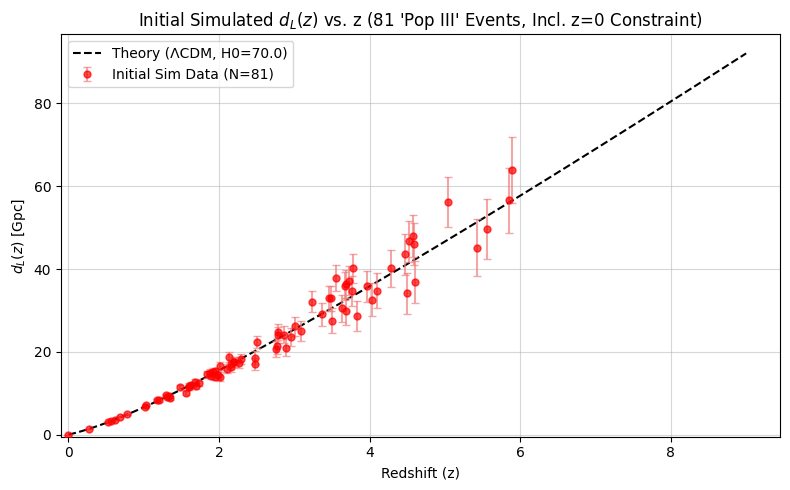

In [8]:
#  Visualize Initial Data
# Generate Initial Dataset for Hyperparameter Tuning
# --------------------------------------------------

# --------------------------------------------------

print("\nVisualizing the initial dataset used for hyperparameter tuning...")
z_plot_theory = np.linspace(0, target_z_max, 300) # Smooth line for theory plot
plt.figure(figsize=(8, 5))

# Plot underlying theoretical curve
plt.plot(z_plot_theory, dL_theory(z_plot_theory) / 1e3, 'k--', lw=1.5, label=f'Theory (ΛCDM, H0={H0})')

# Plot constrained initial data *including* the z=0 point
plt.errorbar(z_data_initial_flat, dL_obs_initial / 1e3, yerr=dL_err_initial / 1e3, fmt='o', ms=5, alpha=0.7,
             color='red', ecolor='lightcoral', capsize=3, label=f'Initial Sim Data (N={len(z_data_initial)})', zorder=5)

plt.xlabel("Redshift (z)")
plt.ylabel(r"$d_L(z)$ [Gpc]")
plt.title(f"Initial Simulated $d_L(z)$ vs. z ({len(z_data_initial)} '{scenario}' Events, Incl. z=0 Constraint)")
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.xlim(-0.1, target_z_max * 1.05) # Start slightly negative to see z=0 point clearly
plt.ylim(min(-0.5, np.min(dL_obs_initial / 1e3)*1.1 ),) #np.max(dL_obs_initial / 1e3) * 1.1) # Adjust ylim to see z=0 point
plt.tight_layout()
plt.show()

In [11]:
# Define Log Posterior for Hyperparameter Optimization
# --------------------------------------------------

# Define the log-posterior function (used by BO and MCMC)
def log_posterior(theta: list[float], z_train: np.ndarray, y_train: np.ndarray, y_err_sq: np.ndarray) -> float:
    """Calculates the log posterior (log marginal likelihood + log prior) for GP hyperparameters."""
    log_l, log_sigma_f = theta
    l = np.exp(log_l)
    sigma_f = np.exp(log_sigma_f)

    # Define reasonable priors on hyperparameters (log-space).
    log_l_min, log_l_max = np.log(0.1), np.log(25.0) # Length scale range (adjust based on z_max)
    sigma_std_guess = np.std(y_train[1:]) # Estimate scale from data (excluding z=0 point)
    if sigma_std_guess <= 0: sigma_std_guess = np.std(y_train) # Fallback if only z=0 point
    if sigma_std_guess <= 0: sigma_std_guess = 1e-6 # Final fallback if std dev is zero

    # Set bounds for sigma_f based on data std dev, ensuring positivity
    log_sigma_f_min = np.log(max(sigma_std_guess / 100, 1e-2)) # Avoid extremely small sigma_f
    log_sigma_f_max = np.log(sigma_std_guess * 100)

    # Prior check: return -inf if outside bounds
    if not (log_l_min < log_l < log_l_max and log_sigma_f_min < log_sigma_f < log_sigma_f_max):
        return -np.inf

    # Define GP Kernel: Matern nu=4.5 => k=5 (C^4 functions, very smooth)
    # Ensure ample smoothness for derivatives needed for H(z)
    kernel = ConstantKernel(sigma_f**2, constant_value_bounds="fixed") * \
             Matern(length_scale=l, nu=4.5, length_scale_bounds="fixed")

    try:
        # Create GP regressor
        # alpha = y_err_sq includes the specific noise variance for each point (incl. tiny error for z=0)
        gp = GaussianProcessRegressor(kernel=kernel, alpha=y_err_sq, optimizer=None, normalize_y=False)

        # Fit the GP to compute the log marginal likelihood implicitly
        # Ensure z_train is 2D: (N_points, 1)
        gp.fit(z_train.reshape(-1, 1), y_train)
        log_like = gp.log_marginal_likelihood_value_

    except (np.linalg.LinAlgError, ValueError):
        # Handle numerical instability during GP fitting (e.g., matrix non-positive definite)
        # print(f"Warning: LinAlgError/ValueError during likelihood calculation for l={l:.3f}, sigma_f={sigma_f:.3f}. {e}")
        return -np.inf # Penalize these hyperparameters heavily

    # Check for NaN likelihood
    if np.isnan(log_like):
        return -np.inf

    # Return log likelihood (priors are uniform in log-space within bounds, so log prior is constant)
    return log_like

print("Log posterior function 'log_posterior' defined for hyperparameter optimization.")

Log posterior function 'log_posterior' defined for hyperparameter optimization.



Starting Bayesian Optimization (BO) to find good initial hyperparameters...
 BO Search Space: l in [0.10, 25.00], sigma_f in [141.15, 1411548.71]
Bayesian Optimization finished in 10.15 seconds (60 calls).
 Best hyperparameters found by BO: l = 5.509, sigma_f = 78969.63
 Corresponding log-hyperparameters: log(l) = 1.706, log(sigma_f) = 11.277


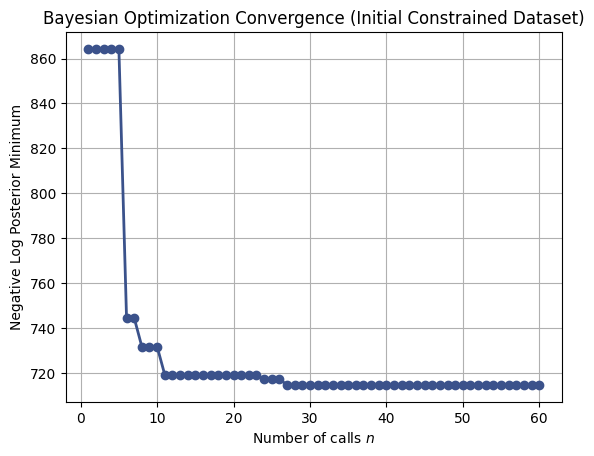

In [12]:
#  Bayesian Optimization (BO) for Initial Hyperparameter Guess
# --------------------------------------------------

print("\nStarting Bayesian Optimization (BO) to find good initial hyperparameters...")

# Define the search space for BO (real-space: l, sigma_f) using stats from the CONSTRAINED INITIAL data
sigma_std_initial = np.std(dL_obs_initial[1:]) # Use std dev excluding z=0 point
if sigma_std_initial <= 0: sigma_std_initial = 1e-6
l_min_bo, l_max_bo = np.exp(np.log(0.1)), np.exp(np.log(25.0))
sigma_f_min_bo = np.exp(np.log(max(sigma_std_initial / 100, 1e-2)))
sigma_f_max_bo = np.exp(np.log(sigma_std_initial * 100))

search_space = [
    Real(l_min_bo, l_max_bo, name='l', prior='log-uniform'),
    Real(sigma_f_min_bo, sigma_f_max_bo, name='sigma_f', prior='log-uniform')
]
print(f" BO Search Space: l in [{l_min_bo:.2f}, {l_max_bo:.2f}], sigma_f in [{sigma_f_min_bo:.2f}, {sigma_f_max_bo:.2f}]")

# Objective function for skopt (minimizes negative log posterior)
# Uses the CONSTRAINED initial dataset
@use_named_args(search_space)
def objective_for_bo(l, sigma_f):
    log_l = np.log(l)
    log_sigma_f = np.log(sigma_f)
    # Pass CONSTRAINED initial data to log_posterior
    log_post = log_posterior([log_l, log_sigma_f], z_data_initial, dL_obs_initial, dL_err_sq_initial)
    # Return large finite number instead of infinity for failed evaluations
    # Minimize negative log posterior => Maximize log posterior
    return -log_post if np.isfinite(log_post) else 1e18

# Run Bayesian Optimization
n_bo_calls = 60          # Number of BO iterations (increase for more complex problems)
n_bo_initial_points = 15 # Number of random points before optimization starts
bo_start_time = time.time()

bo_result = gp_minimize(
    objective_for_bo,
    search_space,
    n_calls=n_bo_calls,
    #random_state=42,          # For reproducibility
    n_initial_points=n_bo_initial_points,
    acq_func='EI',            # Expected Improvement acquisition function
    #verbose=True             # Set to True for detailed BO progress
)
bo_time = time.time() - bo_start_time
print(f"Bayesian Optimization finished in {bo_time:.2f} seconds ({n_bo_calls} calls).")

# Extract the best hyperparameters found by BO
best_l_bo = bo_result.x[0]
best_sigma_f_bo = bo_result.x[1]
initial_theta_bo = np.log([best_l_bo, best_sigma_f_bo]) # Log-space values

print(f" Best hyperparameters found by BO: l = {best_l_bo:.3f}, sigma_f = {best_sigma_f_bo:.2f}")
print(f" Corresponding log-hyperparameters: log(l) = {initial_theta_bo[0]:.3f}, log(sigma_f) = {initial_theta_bo[1]:.3f}")

# Optional: Plot BO convergence
try:
    from skopt.plots import plot_convergence
    plot_convergence(bo_result)
    plt.title("Bayesian Optimization Convergence (Initial Constrained Dataset)")
    plt.ylabel("Negative Log Posterior Minimum")
    plt.show()
except ImportError:
    print("Skipping BO convergence plot: scikit-optimize plotting tools not found.")
except Exception as e:
    print(f"Could not plot BO convergence: {e}")


Setting up MCMC for hyperparameter refinement using BO result as starting point...
 MCMC Settings: 40 walkers, 5000 steps, 2000 burn-in steps.
 MCMC will use multiprocessing pool with 2 workers.
 Running MCMC...


100%|██████████| 5000/5000 [08:34<00:00,  9.73it/s]


 MCMC finished in 514.19 seconds.
 Mean MCMC acceptance fraction: 0.711
 Autocorrelation time estimate (steps): [30.94726157 31.18880047]
 MCMC chain length appears sufficient relative to autocorrelation time.
 Extracting results from 120000 post-burn-in MCMC samples.
 MCMC median l = 5.056 (+1.586 / -1.085)
 MCMC median sigma_f = 42486.90 (+38563.74 / -15787.28)


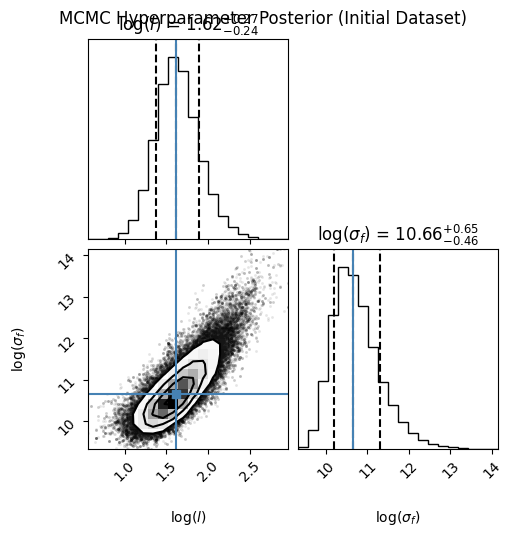

 Multiprocessing pool closed.
----------------------------------------
 Using FIXED hyperparameters for 100 GP runs:
   l = 5.0558
   sigma_f = 42486.8952
   (Derived from MCMC median)
----------------------------------------


In [15]:
#  MCMC for Hyperparameter Refinement
# --------------------------------------------------

print("\nSetting up MCMC for hyperparameter refinement using BO result as starting point...")
# MCMC parameters
ndim = 2      # Number of parameters (log(l), log(sigma_f))
nwalkers = 40 # Number of MCMC walkers (should be > 2*ndim)
nsteps = 5000 # Total number of steps per walker (adjust based on convergence)
nburn =  2000  # Number of burn-in steps to discard (adjust based on convergence)
print(f" MCMC Settings: {nwalkers} walkers, {nsteps} steps, {nburn} burn-in steps.")

# Initialize walkers in a small ball around the BO result
p0 = initial_theta_bo + 1e-3 * np.random.randn(nwalkers, ndim)

# Ensure initial positions are within prior bounds derived in log_posterior
log_l_min_mcmc, log_l_max_mcmc = np.log(0.1), np.log(25.0)
sigma_std_initial_mcmc = np.std(dL_obs_initial[1:]) # Exclude z=0 point for scale estimate
if sigma_std_initial_mcmc <= 0: sigma_std_initial_mcmc = 1e-6
log_sigma_f_min_mcmc = np.log(max(sigma_std_initial_mcmc / 100, 1e-2))
log_sigma_f_max_mcmc = np.log(sigma_std_initial_mcmc * 100)

p0[:, 0] = np.clip(p0[:, 0], log_l_min_mcmc + 1e-6, log_l_max_mcmc - 1e-6)
p0[:, 1] = np.clip(p0[:, 1], log_sigma_f_min_mcmc + 1e-6, log_sigma_f_max_mcmc - 1e-6)

# Run the MCMC sampler with multiprocessing if available
sampler = None
mcmc_succeeded = False
fixed_l = best_l_bo # Initialize with BO result as fallback
fixed_sigma_f = best_sigma_f_bo

# Set up multiprocessing pool context manager
pool_context = None
if n_cpus > 1:
    try:
        pool_context = multiprocessing.Pool(processes=n_cpus)
        print(f" MCMC will use multiprocessing pool with {n_cpus} workers.")
    except Exception as pool_init_e:
        print(f"Warning: Failed to initialize multiprocessing pool: {pool_init_e}. Running MCMC sequentially.")
        n_cpus = 1 # Force sequential run

mcmc_start_time = time.time()
try:
    # Use the CONSTRAINED INITIAL dataset for MCMC fitting
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,
                                    args=(z_data_initial, dL_obs_initial, dL_err_sq_initial),
                                    pool=pool_context) # Pass pool context (None if sequential)
    print(" Running MCMC...")
    # Run MCMC (progress bar will show)
    sampler.run_mcmc(p0, nsteps, progress=True)
    mcmc_time = time.time() - mcmc_start_time
    print(f" MCMC finished in {mcmc_time:.2f} seconds.")

    # --- MCMC Diagnostics ---
    acceptance_fraction = np.mean(sampler.acceptance_fraction)
    print(f" Mean MCMC acceptance fraction: {acceptance_fraction:.3f}")
    if not (0.1 < acceptance_fraction < 0.7):
        print(" Warning: Acceptance fraction outside typical optimal range (0.2-0.5). Check proposal scale/priors if convergence is poor.")

    try:
        autocorr_time = sampler.get_autocorr_time(tol=10) # Use tolerance for stability
        print(f" Autocorrelation time estimate (steps): {autocorr_time}")
        converged = np.all(sampler.iteration > 50 * autocorr_time) # Check if run length > 50 * tau
        if not converged:
             print(f" Warning: Chain might be too short relative to autocorrelation time (steps={sampler.iteration}, 50*tau ~ {50*autocorr_time}). Consider increasing nsteps or check convergence plots.")
        else:
             print(" MCMC chain length appears sufficient relative to autocorrelation time.")
    except emcee.autocorr.AutocorrError as e:
        print(f" Could not estimate autocorrelation time: {e}. Convergence check skipped.")
        converged = False # Assume not converged if check fails

    # --- Extract Results ---
    # Check if enough steps remain after burn-in
    if sampler.iteration > nburn:
        samples_log = sampler.get_chain(discard=nburn, flat=True)
        if samples_log.shape[0] > 0: # Check if any samples remain
            print(f" Extracting results from {samples_log.shape[0]} post-burn-in MCMC samples.")
            l_samples = np.exp(samples_log[:, 0])
            sigma_f_samples = np.exp(samples_log[:, 1])

            # Calculate median and 16/84 percentiles for marginal distributions
            l_median_mcmc, l16, l84 = np.percentile(l_samples, [50, 16, 84])
            sigma_f_median_mcmc, sf16, sf84 = np.percentile(sigma_f_samples, [50, 16, 84])

            print(f" MCMC median l = {l_median_mcmc:.3f} (+{l84-l_median_mcmc:.3f} / -{l_median_mcmc-l16:.3f})")
            print(f" MCMC median sigma_f = {sigma_f_median_mcmc:.2f} (+{sf84-sigma_f_median_mcmc:.2f} / -{sigma_f_median_mcmc-sf16:.2f})")

            # Use these median values as the fixed hyperparameters for the simulation loop
            fixed_l = l_median_mcmc
            fixed_sigma_f = sigma_f_median_mcmc
            mcmc_succeeded = True

            # Optional: Corner plot for MCMC results
            try:
                import corner
                fig = corner.corner(samples_log, labels=[r"$\log(l)$", r"$\log(\sigma_f)$"],
                                    truths=[np.log(fixed_l), np.log(fixed_sigma_f)],
                                    quantiles=[0.16, 0.5, 0.84], show_titles=True)
                fig.suptitle("MCMC Hyperparameter Posterior (Initial Dataset)")
                plt.show()
            except ImportError:
                print(" Skipping corner plot: 'corner' package not installed.")
            except Exception as corner_e:
                 print(f" Could not generate corner plot: {corner_e}")

        else:
            print(" Warning: MCMC chain shorter than burn-in period after flattening. No post-burn-in samples available.")
            print(" Using BO hyperparameter guess as fixed values.")
    else:
         print(f" Warning: MCMC run ({sampler.iteration} steps) shorter than specified burn-in ({nburn} steps).")
         print(" Using BO hyperparameter guess as fixed values.")

except Exception as e:
    print(f" MCMC execution failed: {e}")
    print(" Using BO hyperparameter guess as fixed values.")
finally:
    # Ensure the pool is closed if it was created
    if pool_context:
        try:
            pool_context.close()
            pool_context.join()
            print(" Multiprocessing pool closed.")
        except Exception as pool_e:
            print(f" Error closing multiprocessing pool: {pool_e}")

# --- Final Fixed Hyperparameters ---
print("-" * 40)
print(f" Using FIXED hyperparameters for {N_SIMULATIONS} GP runs:")
print(f"   l = {fixed_l:.4f}")
print(f"   sigma_f = {fixed_sigma_f:.4f}")
if not mcmc_succeeded:
    print("   (Derived from Bayesian Optimization fallback)")
else:
    print("   (Derived from MCMC median)")
print("-" * 40)

In [16]:
#  Main Simulation Loop
# --------------------------------------------------
print(f"\nStarting main loop for {N_SIMULATIONS} mock catalogue simulations...")

# Define test redshift grid for predictions (dense for smooth derivatives)
# Ensure z=0 is explicitly included
z_test = np.linspace(0, target_z_max, 100001).reshape(-1, 1) # Dense grid, includes 0
z_test_flat = z_test.flatten()
print(f" Predictions will be made on a test grid of {len(z_test)} points from z=0 to z={target_z_max}.")

# Containers for results from ALL simulations
all_dL_pred_samples = [] # Store dL(z) predictions from each simulation
all_dL_grad_samples = [] # Store dL'(z) gradients from each simulation
all_H_samples = []       # Store H(z) calculations from each simulation

# Define the FIXED kernel based on MCMC median (or BO fallback)
fixed_kernel = ConstantKernel(fixed_sigma_f**2, constant_value_bounds="fixed") * \
               Matern(length_scale=fixed_l, nu=4.5, length_scale_bounds="fixed")
print(f" Using fixed GP kernel: Constant(sigma_f^2={fixed_sigma_f**2:.2f}) * Matern(l={fixed_l:.3f}, nu=4.5)")

start_loop_time = time.time()
successful_sims = 0

for i in range(N_SIMULATIONS):
    if (i + 1) % 10 == 0 or i == 0: # Print progress every 10 sims and for the first one
        elapsed = time.time() - start_loop_time
        rate = (i + 1) / elapsed if elapsed > 0 else 0
        print(f"  Running simulation {i+1}/{N_SIMULATIONS}... (Elapsed: {elapsed:.1f}s, Rate: {rate:.1f} sims/s)")

    # 1. Generate a NEW raw mock dataset for this simulation (no z=0 yet)
    z_data_sim_raw = generate_z_data(scenario, num_events, target_max_z=target_z_max, min_z=min_z_data)
    if len(z_data_sim_raw) == 0:
        print(f"  Warning: Simulation {i+1} generated 0 events in range. Skipping.")
        continue # Skip this simulation if no data points generated

    z_data_sim_raw_flat = z_data_sim_raw.flatten()
    dL_obs_sim_raw, dL_err_sim_raw = generate_dL_obs(z_data_sim_raw_flat)

    # 2. Add the z=0 constraint to THIS simulation's dataset
    z_data_sim, dL_obs_sim, _, dL_err_sq_sim = add_z0_constraint(
        z_data_sim_raw, dL_obs_sim_raw, dL_err_sim_raw, z0_err_val=z0_constraint_error
    )

    # 3. Create and fit the GP regressor using the FIXED kernel and THIS simulation's data
    gp_sim = GaussianProcessRegressor(kernel=fixed_kernel,
                                      alpha=dL_err_sq_sim, # Noise specific to this simulation
                                      optimizer=None,      # Hyperparameters are fixed
                                      normalize_y=False)
    try:
        # Fit GP: z_data_sim is (N_raw+1, 1), dL_obs_sim is (N_raw+1,)
        gp_sim.fit(z_data_sim, dL_obs_sim)

        # 4. Predict dL on the dense test grid z_test
        # We don't strictly need the GP's internal std prediction here, as we use the spread across simulations
        dL_pred_sim = gp_sim.predict(z_test)
        dL_pred_sim_flat = dL_pred_sim.flatten()
        # Explicitly set dL(0) = 0 in the prediction (GP should be very close due to constraint)
        dL_pred_sim_flat[z_test_flat == 0] = 0.0

        # 5. Calculate the derivative dL/dz using finite differences on the GP prediction
        # np.gradient uses central differences where possible, forward/backward at edges
        dL_grad_sim = np.gradient(dL_pred_sim_flat, z_test_flat)
        # Check derivative at z=0 (should be approx c/H0 ~ 4285 Mpc)
        # print(f" Sim {i+1}: dL'(0) = {dL_grad_sim[0]:.1f}") # Debug print

        # 6. Calculate H(z) = c * (1+z)^2 / [ dL'(z)*(1+z) - dL(z) ] for THIS simulation
        one_plus_z = 1.0 + z_test_flat
        # Calculate denominator: f(z) = dL'(z)*(1+z) - dL(z)
        denom_sim = dL_grad_sim * one_plus_z - dL_pred_sim_flat
        # Initialize H(z) array with NaNs
        H_sim = np.full_like(denom_sim, np.nan)

        # Define mask for physically valid points (denominator > small positive threshold)
        # The threshold prevents division by zero or very small numbers amplifying noise.
        # denom_sim[0] should be approx dL'(0) > 0.
        valid_denom_mask_sim = denom_sim > 1e-1 # Threshold (adjust if needed)

        # Compute H(z) only where the denominator is valid for this simulation
        H_sim[valid_denom_mask_sim] = c_km * (one_plus_z[valid_denom_mask_sim]**2) / denom_sim[valid_denom_mask_sim]

        # Special handling for H(0) = c / dL'(0)
        # Use the calculated gradient at z=0 if it's positive
        if dL_grad_sim[0] > 1e-1: # Check if derivative at 0 is valid and positive
             H_sim[0] = c_km / dL_grad_sim[0]
        else:
             # If dL'(0) is invalid, H(0) cannot be computed reliably for this sim
             H_sim[0] = np.nan
             # print(f"  Warning Sim {i+1}: Invalid dL'(0) = {dL_grad_sim[0]:.2f}. Setting H(0) to NaN.")


        # Store results for this simulation
        all_dL_pred_samples.append(dL_pred_sim_flat)
        all_dL_grad_samples.append(dL_grad_sim)
        all_H_samples.append(H_sim) # Store H(z) from this sim
        successful_sims += 1

    except np.linalg.LinAlgError as e_fit:
         print(f"  Warning: GP fit failed for simulation {i+1} (LinAlgError: {e_fit}). Skipping.")
         continue # Skip to next simulation
    except Exception as e:
        print(f"  Warning: Error during GP processing for simulation {i+1}: {e}. Skipping.")
        continue # Skip to next simulation

loop_time = time.time() - start_loop_time
print("-" * 40)
print(f"Finished {successful_sims}/{N_SIMULATIONS} successful simulations in {loop_time:.2f} seconds.")
if successful_sims == 0:
    raise RuntimeError("No simulations completed successfully. Cannot proceed.")


Starting main loop for 100 mock catalogue simulations...
 Predictions will be made on a test grid of 100001 points from z=0 to z=9.0.
 Using fixed GP kernel: Constant(sigma_f^2=1805136263.26) * Matern(l=5.056, nu=4.5)
  Running simulation 1/100... (Elapsed: 0.0s, Rate: 2149.8 sims/s)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
Generating redshifts for 'pop iii' scenario (alpha=2.64, beta=6.03)
  Running simulation 10/100... (Elapsed: 16.4s, Rate: 0.6 sims/s)
Generating redshifts for 'pop iii' s

In [17]:
# Post-Loop Analysis: Calculate Mean and Standard Deviation
# --------------------------------------------------
print("\nCalculating mean and standard deviation across successful simulations...")

# Convert lists of results into numpy arrays (shape: N_success x N_ztest)
all_dL_pred_samples = np.array(all_dL_pred_samples)
all_dL_grad_samples = np.array(all_dL_grad_samples)
all_H_samples = np.array(all_H_samples) # H(z) samples from each sim

print(f" Ensemble Shapes: dL({all_dL_pred_samples.shape}), dL'({all_dL_grad_samples.shape}), H({all_H_samples.shape})")

# Compute ensemble mean and standard deviation using nanmean/nanstd
# This handles potential NaNs introduced in H(z) calculation for individual sims
print(" Computing dL(z) statistics...")
dL_mean_final = np.nanmean(all_dL_pred_samples, axis=0)
dL_std_final = np.nanstd(all_dL_pred_samples, axis=0)

print(" Computing dL'(z) statistics...")
dL_grad_mean_final = np.nanmean(all_dL_grad_samples, axis=0)
dL_grad_std_final = np.nanstd(all_dL_grad_samples, axis=0)

print(" Computing H(z) statistics...")
H_mean_final = np.nanmean(all_H_samples, axis=0) # Mean H(z) across simulations
H_std_final = np.nanstd(all_H_samples, axis=0)   # Std dev H(z) across simulations (our uncertainty)

print(" Averaged reconstructions computed.")

# --- Report H(0) reconstruction ---
print("\n--- H(0) Reconstruction Result ---")
# Find the index corresponding to z=0 in the test grid
z0_index = np.argmin(np.abs(z_test_flat))

if z_test_flat[z0_index] == 0:
    H0_recon_mean = H_mean_final[z0_index]
    H0_recon_std = H_std_final[z0_index]
    if np.isnan(H0_recon_mean) or np.isnan(H0_recon_std):
         print(" Result: Reconstructed H(0) is NaN. Check GP fits or H(z) calculation near z=0.")
         print(f"   dL'(0) mean: {dL_grad_mean_final[z0_index]:.2f} +/- {dL_grad_std_final[z0_index]:.2f}")
    else:
         print(f" Input Fiducial H0 = {H0:.2f} km/s/Mpc")
         print(f" Mean Reconstructed H(0) = {H0_recon_mean:.2f} km/s/Mpc")
         print(f" Std Dev Reconstructed H(0) = {H0_recon_std:.2f} km/s/Mpc (from {successful_sims} simulations)")
         # Calculate relative error and deviation from fiducial
         relative_error_percent = (H0_recon_std / H0_recon_mean) * 100 if H0_recon_mean != 0 else np.inf
         deviation_sigma = abs(H0_recon_mean - H0) / H0_recon_std if H0_recon_std > 0 else np.inf
         print(f" Relative Uncertainty = {relative_error_percent:.2f}%")
         print(f" Deviation from Fiducial = {abs(H0_recon_mean - H0):.2f} ({deviation_sigma:.1f} sigma)")
else:
    print(" Warning: Could not find exact z=0 in z_test grid to report H(0).")
print("----------------------------------\n")


Calculating mean and standard deviation across successful simulations...
 Ensemble Shapes: dL((100, 100001)), dL'((100, 100001)), H((100, 100001))
 Computing dL(z) statistics...
 Computing dL'(z) statistics...
 Computing H(z) statistics...
 Averaged reconstructions computed.

--- H(0) Reconstruction Result ---
 Input Fiducial H0 = 70.00 km/s/Mpc
 Mean Reconstructed H(0) = 66.20 km/s/Mpc
 Std Dev Reconstructed H(0) = 2.63 km/s/Mpc (from 100 simulations)
 Relative Uncertainty = 3.97%
 Deviation from Fiducial = 3.80 (1.4 sigma)
----------------------------------



<ipython-input-17-3cd268a8d84d>:23: RuntimeWarning: Mean of empty slice
  H_mean_final = np.nanmean(all_H_samples, axis=0) # Mean H(z) across simulations
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Plotting dL(z) reconstruction...


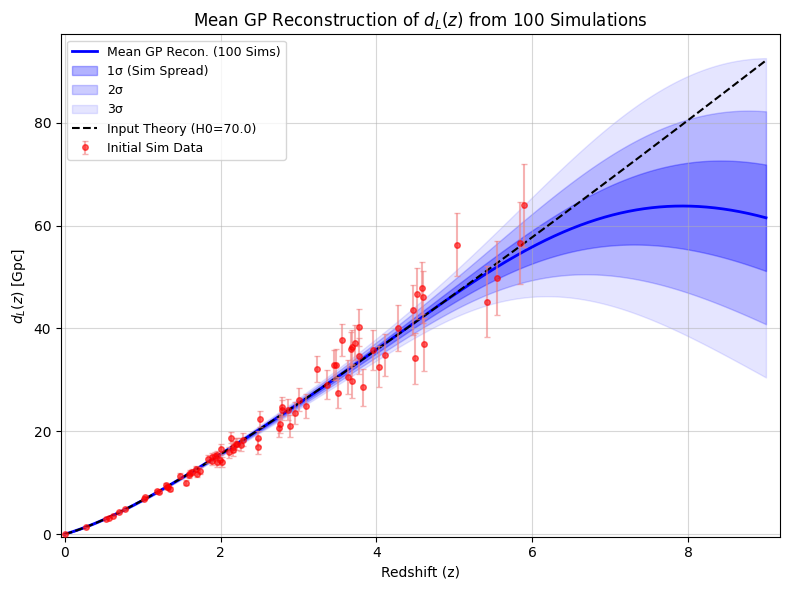

In [18]:
#  Plotting: dL(z) Reconstruction
# --------------------------------------------------
print("\nPlotting dL(z) reconstruction...")
plt.figure(figsize=(8, 6))

# Plot MEAN dL prediction across simulations
plt.plot(z_test_flat, dL_mean_final / 1e3, color='blue', linestyle='-', lw=2, label=f'Mean GP Recon. ({successful_sims} Sims)')
# Plot 1, 2, 3 sigma uncertainty bands (std dev across simulations)
plt.fill_between(z_test_flat, (dL_mean_final - dL_std_final) / 1e3, (dL_mean_final + dL_std_final) / 1e3,
                 color='blue', alpha=0.3, label='1σ (Sim Spread)')
plt.fill_between(z_test_flat, (dL_mean_final - 2*dL_std_final) / 1e3, (dL_mean_final + 2*dL_std_final) / 1e3,
                 color='blue', alpha=0.2, label='2σ')
plt.fill_between(z_test_flat, (dL_mean_final - 3*dL_std_final) / 1e3, (dL_mean_final + 3*dL_std_final) / 1e3,
                 color='blue', alpha=0.1, label='3σ')

# Plot underlying theoretical curve
plt.plot(z_test_flat, dL_theory(z_test_flat) / 1e3, 'k--', lw=1.5, label=f'Input Theory (H0={H0})')

# Plot the INITIAL simulated data points for context
plt.errorbar(z_data_initial_flat, dL_obs_initial / 1e3, yerr=dL_err_initial / 1e3, fmt='o', color='red', ecolor='lightcoral',
             markersize=4, alpha=0.6, capsize=2, label='Initial Sim Data', zorder=10)

plt.xlabel("Redshift (z)")
plt.ylabel(r"$d_L(z)$ [Gpc]")
plt.title(f"Mean GP Reconstruction of $d_L(z)$ from {successful_sims} Simulations")
plt.legend(loc='upper left', fontsize=9)
plt.grid(alpha=0.5)
plt.xlim(-0.05, target_z_max * 1.02) # Show origin clearly
plt.ylim(bottom=min(-0.5, np.min((dL_mean_final - dL_std_final)/1e3)*1.1)) # Adjust ylim
plt.tight_layout()
plt.show()

Plotting dL'(z) reconstruction...


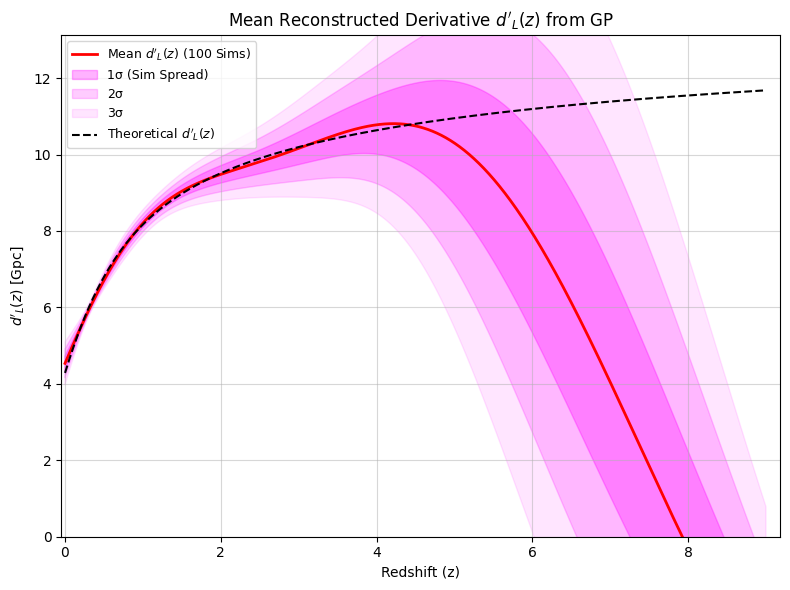

In [19]:
#  Plotting: dL'(z) Reconstruction
# --------------------------------------------------
print("Plotting dL'(z) reconstruction...")
plt.figure(figsize=(8, 6))

# Plot MEAN gradient across simulations
plt.plot(z_test_flat, dL_grad_mean_final / 1e3, color='red', linestyle='-', lw=2, label=f"Mean $d'_L(z)$ ({successful_sims} Sims)")
# Plot uncertainty bands for the gradient (std dev across simulations)
plt.fill_between(z_test_flat, (dL_grad_mean_final - dL_grad_std_final) / 1e3, (dL_grad_mean_final + dL_grad_std_final) / 1e3,
                 color='magenta', alpha=0.3, label='1σ (Sim Spread)')
plt.fill_between(z_test_flat, (dL_grad_mean_final - 2*dL_grad_std_final) / 1e3, (dL_grad_mean_final + 2*dL_grad_std_final) / 1e3,
                 color='magenta', alpha=0.2, label='2σ')
plt.fill_between(z_test_flat, (dL_grad_mean_final - 3*dL_grad_std_final) / 1e3, (dL_grad_mean_final + 3*dL_grad_std_final) / 1e3,
                 color='magenta', alpha=0.1, label='3σ')

# Plot theoretical derivative for comparison
# Using a slightly denser grid for theoretical derivative is better
z_dense_deriv = np.linspace(z_test_flat.min(), z_test_flat.max(), 10000)
dL_th_dense_deriv = dL_theory(z_dense_deriv)
dL_th_grad = np.gradient(dL_th_dense_deriv, z_dense_deriv)
plt.plot(z_dense_deriv, dL_th_grad / 1e3, 'k--', lw=1.5, label="Theoretical $d'_L(z)$")

plt.xlabel("Redshift (z)")
plt.ylabel(r"$d'_L(z)$ [Gpc]") # Units of dL/dz are Gpc
plt.title("Mean Reconstructed Derivative $d'_L(z)$ from GP")
plt.legend(loc='upper left', fontsize=9)
plt.grid(alpha=0.5)
plt.xlim(-0.05, target_z_max * 1.02)
# Auto-scale y-axis usually ok for derivatives, set lower bound maybe
# Theoretical dL'(0) ~ c/H0 / 1000 ~ 4.28 Gpc
ymin_grad = 0 #np.min(dL_grad_mean_final/1e3)*0.8
ymax_grad = np.max((dL_grad_mean_final + dL_grad_std_final)/1e3) * 1.1
plt.ylim(ymin_grad, ymax_grad)
plt.tight_layout()
plt.show()

Plotting H(z) reconstruction (Zoomed to z=4)...
 Plotted uncertainty bands using clipped std dev (max = 2 * H_mean) for zoom plot.


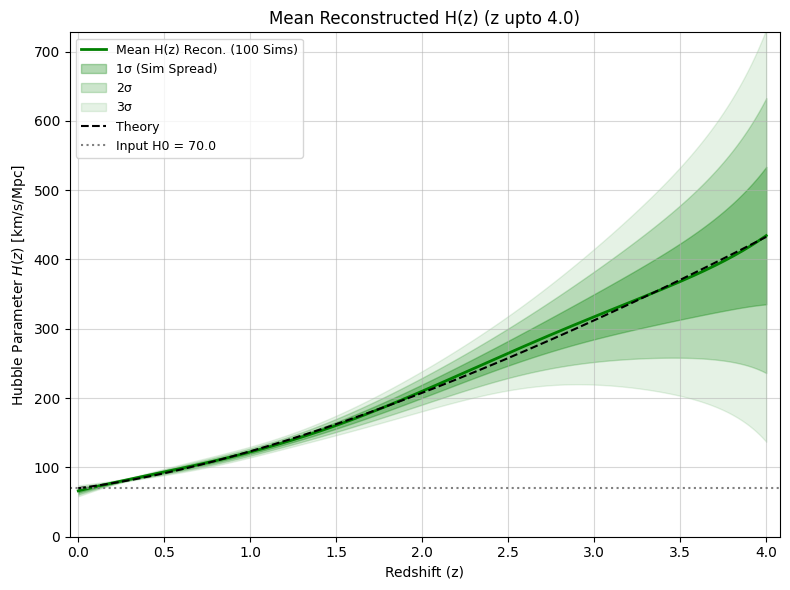

In [20]:
# Plotting: H(z) Reconstruction (up to z=4)
# --------------------------------------------------
print("Plotting H(z) reconstruction (Zoomed to z=4)...")
zoom_z_max = 4.0
plt.figure(figsize=(8, 6))

# Define mask where mean H(z) is finite
valid_H_mask = np.isfinite(H_mean_final)
# Further mask for the zoom range
zoom_range_mask = (z_test_flat >= 0) & (z_test_flat <= zoom_z_max)

# Plot the mean reconstructed H(z) within the zoom range
plt.plot(z_test_flat[valid_H_mask & zoom_range_mask],
         H_mean_final[valid_H_mask & zoom_range_mask],
         color='green', linestyle='-', lw=2, label=f'Mean H(z) Recon. ({successful_sims} Sims)')

# Plot uncertainty bands using H_std_final, clipped for visual clarity
valid_plot_mask = valid_H_mask & np.isfinite(H_std_final)
if np.any(valid_plot_mask & zoom_range_mask):
    # Clip std dev for visual clarity (optional)
    H_std_final_clipped = np.clip(H_std_final, a_min=0, a_max=H_mean_final * 2)

    # Create combined mask for plotting fill_between
    plot_mask_zoom = valid_plot_mask & zoom_range_mask

    plt.fill_between(z_test_flat[plot_mask_zoom],
                     (H_mean_final - H_std_final_clipped)[plot_mask_zoom],
                     (H_mean_final + H_std_final_clipped)[plot_mask_zoom],
                     color='green', alpha=0.3, label='1σ (Sim Spread)')
    plt.fill_between(z_test_flat[plot_mask_zoom],
                     (H_mean_final - 2*H_std_final_clipped)[plot_mask_zoom],
                     (H_mean_final + 2*H_std_final_clipped)[plot_mask_zoom],
                     color='green', alpha=0.2, label='2σ')
    plt.fill_between(z_test_flat[plot_mask_zoom],
                     (H_mean_final - 3*H_std_final_clipped)[plot_mask_zoom],
                     (H_mean_final + 3*H_std_final_clipped)[plot_mask_zoom],
                      color='green', alpha=0.1, label='3σ' )
    print(f" Plotted uncertainty bands using clipped std dev (max = 2 * H_mean) for zoom plot.")
else:
    print(" No valid points with finite uncertainty to plot H(z) bands for zoomed plot.")

# Plot the theoretical H(z) = H0 * E(z) for comparison
H_theory = H0 * E(z_test_flat)
plt.plot(z_test_flat[zoom_range_mask], H_theory[zoom_range_mask], 'k--', lw=1.5, label=f'Theory')

# Add horizontal line at H0
plt.axhline(H0, color='grey', linestyle=':', lw=1.5, label=f'Input H0 = {H0}')

plt.xlabel("Redshift (z)")
plt.ylabel(r"Hubble Parameter $H(z)$ [km/s/Mpc]")
plt.title(f"Mean Reconstructed H(z) (z upto {zoom_z_max})")
plt.legend(loc='upper left', fontsize=9)
plt.grid(alpha=0.5)
plt.xlim(-0.05, zoom_z_max * 1.02) # Zoomed x-axis limit

# Adjust y-limits for the zoomed view
ymin_zoom = 0
z_mask_for_ylim = valid_plot_mask & zoom_range_mask
if np.any(z_mask_for_ylim):
    valid_upper_bounds_zoom = (H_mean_final + 2*H_std_final_clipped)[z_mask_for_ylim]
    # Use nanmax in case clipped std dev still results in NaN when added to NaN mean
    ymax_data_zoom = np.nanmax(valid_upper_bounds_zoom)
else:
    ymax_data_zoom = H0 * E(zoom_z_max)

ymax_theory_zoom = H0 * E(zoom_z_max)
ymax_zoom = max(ymax_data_zoom if np.isfinite(ymax_data_zoom) else 0, ymax_theory_zoom) * 1.15 # Add 15% margin
# Limit max y similar to original example if needed, e.g., 1000 or based on theory
plt.ylim(ymin_zoom, min(max(ymax_zoom, H0*1.5), 1000))

plt.tight_layout()
plt.show()